In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib as mpl
import numpy as np
import scipy as sp
import json
import sys

In [12]:
df = pd.read_csv('../autoinhibition_protein_data/df_copy.tsv', sep='\t').astype('object')
df = df.astype({'smallest_dif': 'float'})
df_min = df[['conformation', 'uniprot', 'smallest_dif']]

In [13]:
plt.style.use('ggplot')

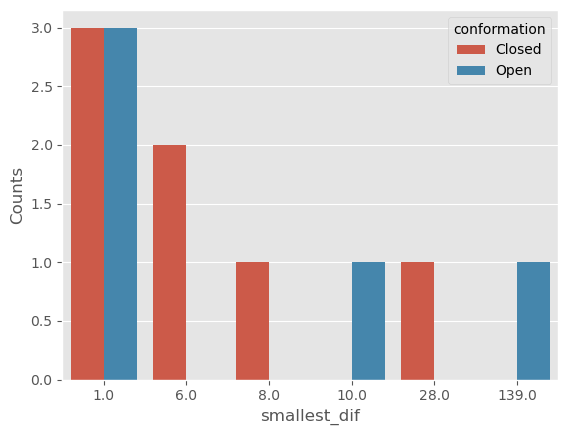

In [14]:
# Make a dataframe with the number of counts of each conformation at each minimum sequence distance
df_min = df_min[['conformation', 'smallest_dif']]
df_min['Counts'] = df_min.groupby(['smallest_dif'])['conformation'].transform('count')

g = sns.barplot(x='smallest_dif', y='Counts', hue='conformation', data=df_min.drop_duplicates())



# ax = sns.barplot(x="smallest_dif", y='counts'

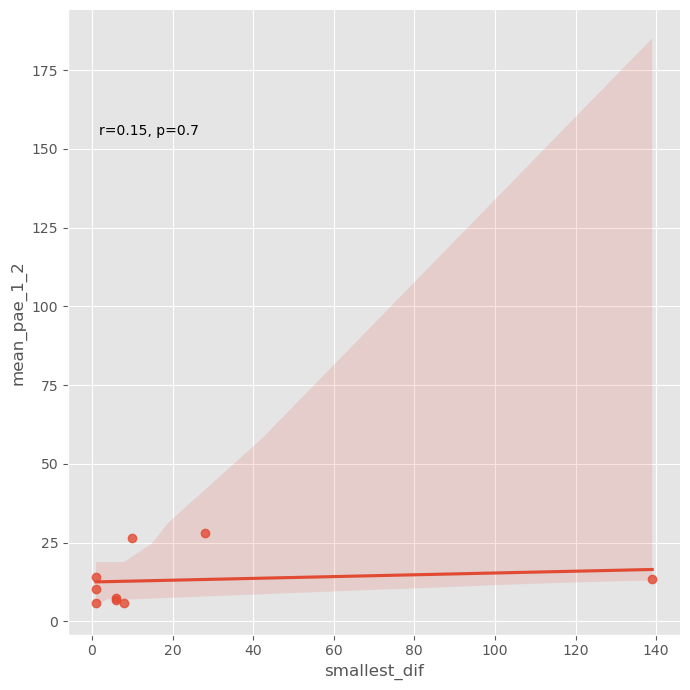

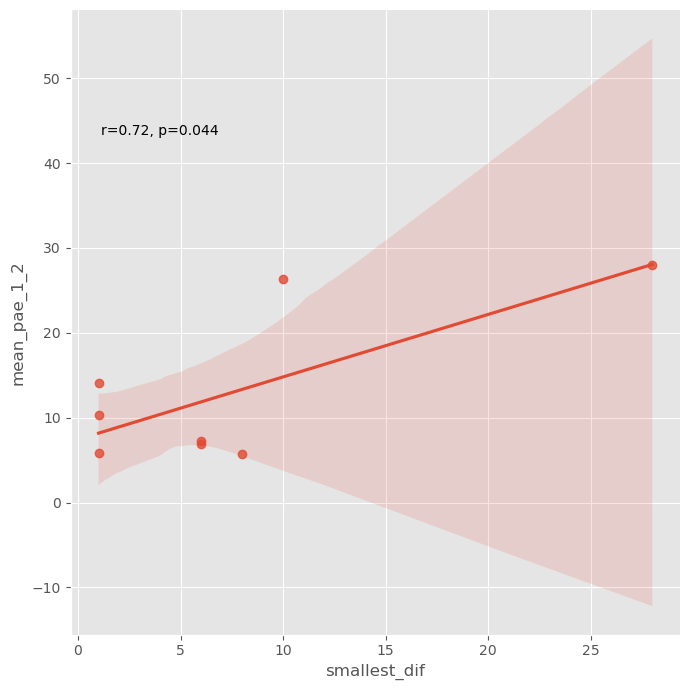

In [15]:
df_num = df[['mean_pae_1_2', 'smallest_dif']].astype('float')
df_no_outlier = df_num[df_num['smallest_dif'] < 100.0]

g = sns.lmplot(x='smallest_dif', y='mean_pae_1_2', data=df_num, height=7, aspect=1)
g2 = sns.lmplot(x='smallest_dif', y='mean_pae_1_2', data=df_no_outlier, height=7, aspect=1)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['smallest_dif'], data['mean_pae_1_2'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g2.map_dataframe(annotate)